<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 392, '日付': '2020-12-21T08:00:00.000Z'},
 {'小計': 563, '日付': '2020-12-22T08:00:00.000Z'},
 {'小計': 748, '日付': '2020-12-23T08:00:00.000Z'},
 {'小計': 888, '日付': '2020-12-24T08:00:00.000Z'},
 {'小計': 884, '日付': '2020-12-25T08:00:00.000Z'},
 {'小計': 949, '日付': '2020-12-26T08:00:00.000Z'},
 {'小計': 708, '日付': '2020-12-27T08:00:00.000Z'},
 {'小計': 481, '日付': '2020-12-28T08:00:00.000Z'},
 {'小計': 856, '日付': '2020-12-29T08:00:00.000Z'},
 {'小計': 944, '日付': '2020-12-30T08:00:00.000Z'},
 {'小計': 1337, '日付': '2020-12-31T08:00:00.000Z'},
 {'小計': 783, '日付': '2021-01-01T08:00:00.000Z'},
 {'小計': 814, '日付': '2021-01-02T08:00:00.000Z'},
 {'小計': 816, '日付': '2021-01-03T08:00:00.000Z'},
 {'小計': 884, '日付': '2021-01-04T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2020-12-31 17:00:00+09:00,1196,0,1337,2020-12-31 17:00:00+09:00
2021-01-01 17:00:00+09:00,948,0,783,2021-01-01 17:00:00+09:00
2021-01-02 17:00:00+09:00,1146,0,814,2021-01-02 17:00:00+09:00
2021-01-03 17:00:00+09:00,1091,0,816,2021-01-03 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2020-12-31 17:00:00+09:00,1196,0,1337,2020-12-31 17:00:00+09:00,1070.714286,7495.0,0.0,0.0,879.857143,6159.0
2021-01-01 17:00:00+09:00,948,0,783,2021-01-01 17:00:00+09:00,1108.428571,7759.0,0.0,0.0,865.428571,6058.0
2021-01-02 17:00:00+09:00,1146,0,814,2021-01-02 17:00:00+09:00,1126.571429,7886.0,0.0,0.0,846.142857,5923.0
2021-01-03 17:00:00+09:00,1091,0,816,2021-01-03 17:00:00+09:00,1153.571429,8075.0,0.0,0.0,861.571429,6031.0
2021-01-04 17:00:00+09:00,0,0,884,2021-01-04 17:00:00+09:00,1028.000000,7196.0,0.0,0.0,919.142857,6434.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2020-12-21 17:00:00+09:00,595,0,392,2020-12-21 17:00:00+09:00,581.285714,4069.0,0.0,0.0,614.857143,4304.0,'20w52,Mon
2020-12-22 17:00:00+09:00,571,0,563,2020-12-22 17:00:00+09:00,600.285714,4202.0,0.0,0.0,630.000000,4410.0,'20w52,Tue
2020-12-23 17:00:00+09:00,667,0,748,2020-12-23 17:00:00+09:00,621.714286,4352.0,0.0,0.0,640.000000,4480.0,'20w52,Wed
2020-12-24 17:00:00+09:00,719,0,888,2020-12-24 17:00:00+09:00,636.285714,4454.0,0.0,0.0,649.571429,4547.0,'20w52,Thu
2020-12-25 17:00:00+09:00,684,0,884,2020-12-25 17:00:00+09:00,650.714286,4555.0,0.0,0.0,681.000000,4767.0,'20w52,Fri
2020-12-26 17:00:00+09:00,1019,0,949,2020-12-26 17:00:00+09:00,690.857143,4836.0,0.0,0.0,711.428571,4980.0,'20w52,Sat
2020-12-27 17:00:00+09:00,902,0,708,2020-12-27 17:00:00+09:00,736.714286,5157.0,0.0,0.0,733.142857,5132.0,'20w52,Sun
2020-12-28 17:00:00+09:00,879,0,481,2020-12-28 17:00:00+09:00,777.285714,5441.0,0.0,0.0,745.857143,5221.0,'20w53,Mon
2020-12-29 17:00:00+09:00,1372,0,856,2020-12-29 17:00:00+09:00,891.714286,6242.0,0.0,0.0,787.714286,5514.0,'20w53,Tue
2020-12-30 17:00:00+09:00,1443,0,944,2020-12-30 17:00:00+09:00,1002.571429,7018.0,0.0,0.0,815.714286,5710.0,'20w53,Wed


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2020-12-20 17:00:00+09:00,602.428571,4217
2020-12-27 17:00:00+09:00,733.142857,5132
2020-12-31 17:00:00+09:00,904.500000,3618
2021-01-04 17:00:00+09:00,884.000000,884
2021-01-03 17:00:00+09:00,804.333333,2413


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2020-12-21 17:00:00+09:00,595,0,392,2020-12-21 17:00:00+09:00,581.285714,4069.0,0.0,0.0,614.857143,4304.0,'20w52,Mon,NaN,NaN
2020-12-22 17:00:00+09:00,571,0,563,2020-12-22 17:00:00+09:00,600.285714,4202.0,0.0,0.0,630.000000,4410.0,'20w52,Tue,NaN,NaN
2020-12-23 17:00:00+09:00,667,0,748,2020-12-23 17:00:00+09:00,621.714286,4352.0,0.0,0.0,640.000000,4480.0,'20w52,Wed,NaN,NaN
2020-12-24 17:00:00+09:00,719,0,888,2020-12-24 17:00:00+09:00,636.285714,4454.0,0.0,0.0,649.571429,4547.0,'20w52,Thu,NaN,NaN
2020-12-25 17:00:00+09:00,684,0,884,2020-12-25 17:00:00+09:00,650.714286,4555.0,0.0,0.0,681.000000,4767.0,'20w52,Fri,NaN,NaN
2020-12-26 17:00:00+09:00,1019,0,949,2020-12-26 17:00:00+09:00,690.857143,4836.0,0.0,0.0,711.428571,4980.0,'20w52,Sat,NaN,NaN
2020-12-27 17:00:00+09:00,902,0,708,2020-12-27 17:00:00+09:00,736.714286,5157.0,0.0,0.0,733.142857,5132.0,'20w52,Sun,733.142857,5132.0
2020-12-28 17:00:00+09:00,879,0,481,2020-12-28 17:00:00+09:00,777.285714,5441.0,0.0,0.0,745.857143,5221.0,'20w53,Mon,NaN,NaN
2020-12-29 17:00:00+09:00,1372,0,856,2020-12-29 17:00:00+09:00,891.714286,6242.0,0.0,0.0,787.714286,5514.0,'20w53,Tue,NaN,NaN
2020-12-30 17:00:00+09:00,1443,0,944,2020-12-30 17:00:00+09:00,1002.571429,7018.0,0.0,0.0,815.714286,5710.0,'20w53,Wed,NaN,NaN


### グラフ出力

In [12]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
y1_4 = df3['patients_week_mean']

In [13]:
### 週毎の数
y2_1 = df3['patients_7d_mov_sum']
y2_2 = df3['patients_week_sum']

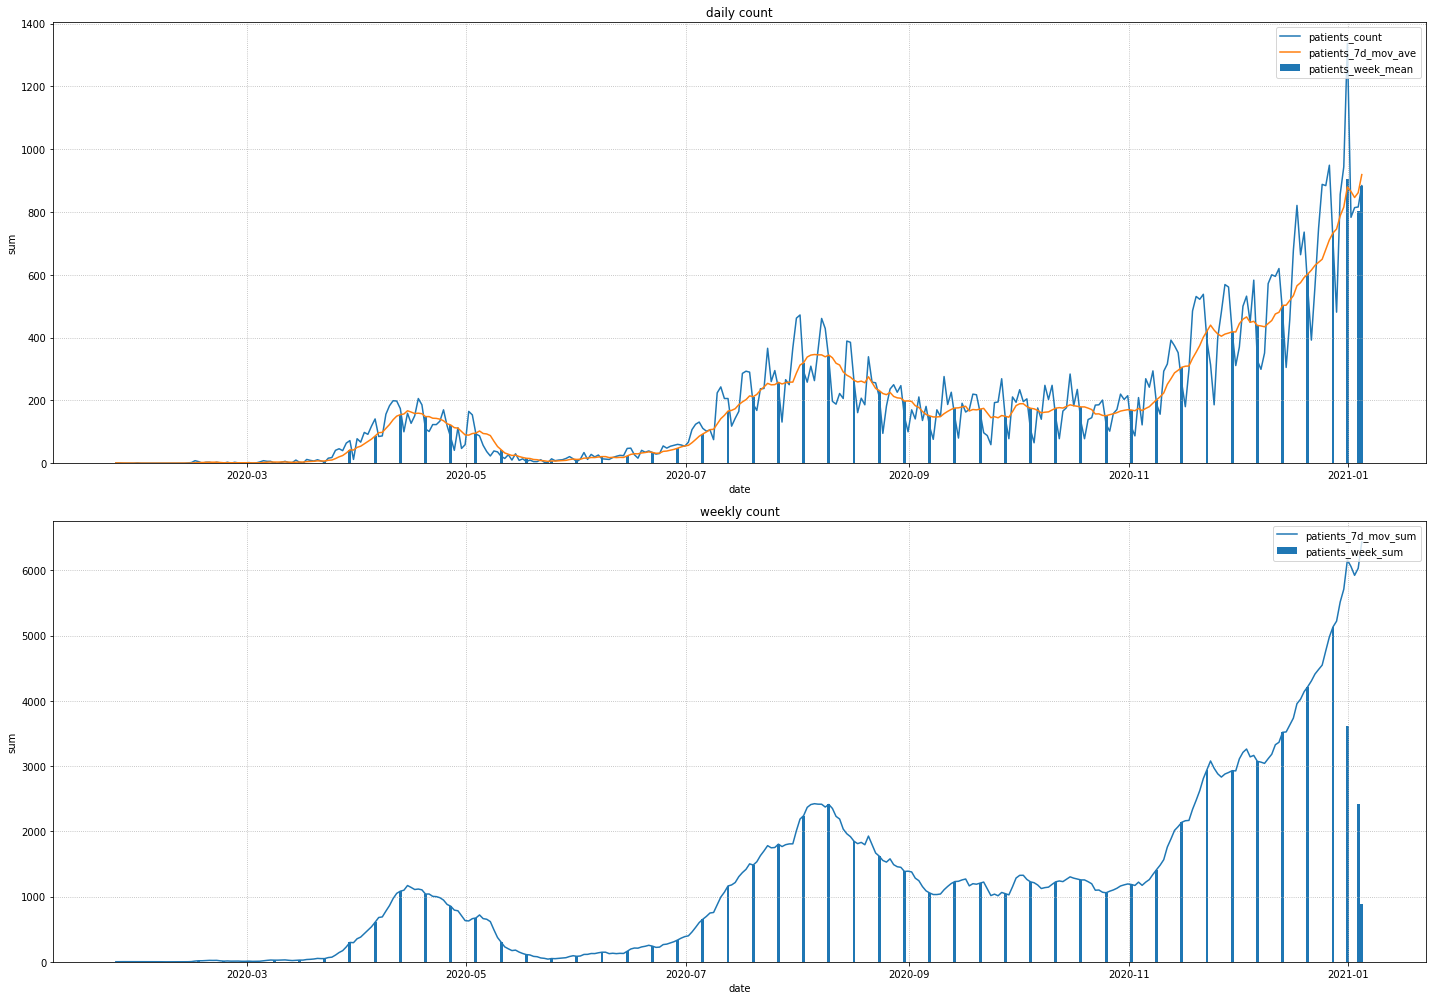

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(20, 14))

### 日毎の数
ax[0].set_title('daily count')
ax[0].set_xlabel('date')
ax[0].set_ylabel('sum')
ax[0].plot(x, y1_1, label='patients_count')
ax[0].plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
ax[0].bar(x, y1_4, label='patients_week_mean')
ax[0].grid(linestyle=':')
ax[0].legend()

### 週毎の合計
ax[1].set_title('weekly count')
ax[1].set_xlabel('date')
ax[1].set_ylabel('sum')
ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
ax[1].bar(x, y2_2, label='patients_week_sum')
ax[1].grid(linestyle=':')
ax[1].legend()

plt.tight_layout()

---

In [15]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [16]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [17]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [18]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [19]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
332,1.608538e+09,2020,12,21,0,1,0,0,0,0,0,332,0,258,595,581.285714,4069.0,0,0.0,0.0,392,614.857143,4304.0
333,1.608624e+09,2020,12,22,0,0,0,0,0,1,0,333,0,259,571,600.285714,4202.0,0,0.0,0.0,563,630.000000,4410.0
334,1.608710e+09,2020,12,23,0,0,0,0,0,0,1,334,0,260,667,621.714286,4352.0,0,0.0,0.0,748,640.000000,4480.0
335,1.608797e+09,2020,12,24,0,0,0,0,1,0,0,335,0,261,719,636.285714,4454.0,0,0.0,0.0,888,649.571429,4547.0
336,1.608883e+09,2020,12,25,1,0,0,0,0,0,0,336,0,262,684,650.714286,4555.0,0,0.0,0.0,884,681.000000,4767.0
337,1.608970e+09,2020,12,26,0,0,1,0,0,0,0,337,0,263,1019,690.857143,4836.0,0,0.0,0.0,949,711.428571,4980.0
338,1.609056e+09,2020,12,27,0,0,0,1,0,0,0,338,0,264,902,736.714286,5157.0,0,0.0,0.0,708,733.142857,5132.0
339,1.609142e+09,2020,12,28,0,1,0,0,0,0,0,339,0,265,879,777.285714,5441.0,0,0.0,0.0,481,745.857143,5221.0
340,1.609229e+09,2020,12,29,0,0,0,0,0,1,0,340,0,266,1372,891.714286,6242.0,0,0.0,0.0,856,787.714286,5514.0
341,1.609315e+09,2020,12,30,0,0,0,0,0,0,1,341,0,267,1443,1002.571429,7018.0,0,0.0,0.0,944,815.714286,5710.0


In [20]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            347 non-null    float64
 1   year                 347 non-null    int64  
 2   month                347 non-null    int64  
 3   day                  347 non-null    int64  
 4   Fri                  347 non-null    uint8  
 5   Mon                  347 non-null    uint8  
 6   Sat                  347 non-null    uint8  
 7   Sun                  347 non-null    uint8  
 8   Thu                  347 non-null    uint8  
 9   Tue                  347 non-null    uint8  
 10  Wed                  347 non-null    uint8  
 11  passed               347 non-null    int64  
 12  emergency            347 non-null    int64  
 13  em_passed            347 non-null    int64  
 14  contacts_count       347 non-null    int64  
 15  contacts_7d_mov_ave  347 non-null    flo

In [21]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,3.470000e+02,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.00000,347.000000,347.000000
mean,1.594800e+09,2020.011527,6.815562,15.853026,0.144092,0.144092,0.144092,0.144092,0.141210,0.141210,0.141210,173.000000,0.141210,106.997118,749.927954,743.046864,5201.317003,1062.014409,1062.014409,7434.100865,182.92219,175.268547,1226.832853
std,8.667173e+06,0.106899,3.292221,8.961302,0.351690,0.351690,0.351690,0.351690,0.348741,0.348741,0.348741,100.314505,0.348741,89.512666,465.372389,450.980956,3156.884861,863.873009,729.558230,5106.907609,208.80514,186.321202,1304.292589
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1.587326e+09,2020.000000,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,86.500000,0.000000,12.500000,453.000000,458.142857,3207.000000,156.000000,352.428571,2467.000000,19.00000,18.642857,130.500000
50%,1.594800e+09,2020.000000,7.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,173.000000,0.000000,99.000000,601.000000,611.857143,4283.000000,1103.000000,1085.571429,7599.000000,132.00000,152.285714,1066.000000
75%,1.602274e+09,2020.000000,10.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,259.500000,0.000000,185.500000,896.500000,901.357143,6309.500000,1701.500000,1602.000000,11214.000000,247.50000,235.285714,1647.000000
max,1.609747e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,346.000000,1.000000,272.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,1337.00000,919.142857,6434.000000


In [22]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.184889,0.925447,0.014407,-0.006144,0.006144,-0.002048,0.002048,0.004048,-0.004048,4.897854e-18,1.000000e+00,-0.303609,0.987888,-0.091742,-0.071549,-0.071542,-0.169668,-0.157245,-0.157245,0.744661,0.791723,0.791758
year,1.848885e-01,1.000000,-0.191035,-0.161146,0.032567,0.032567,0.032567,0.032567,-0.043790,-0.043790,-4.378979e-02,1.848885e-01,-0.043790,0.197538,0.010765,0.086591,0.086591,-0.132951,-0.157427,-0.157427,0.332161,0.405023,0.405014
month,9.254471e-01,-0.191035,1.000000,-0.011991,-0.019415,-0.006935,-0.014423,-0.009431,0.020233,0.012681,1.771527e-02,9.254471e-01,-0.284358,0.907637,-0.095131,-0.103152,-0.103145,-0.115837,-0.091451,-0.091451,0.610738,0.630711,0.630754
day,1.440668e-02,-0.161146,-0.011991,1.000000,0.006739,0.003988,-0.004265,-0.013436,0.010359,0.003886,-7.211868e-03,1.440668e-02,-0.007212,0.018141,0.014071,0.000170,0.000165,-0.002741,-0.027155,-0.027155,0.039580,0.023672,0.023633
Fri,-6.144138e-03,0.032567,-0.019415,0.006739,1.000000,-0.168350,-0.168350,-0.168350,-0.166378,-0.166378,-1.663783e-01,-6.144138e-03,-0.001426,-0.004210,-0.019944,-0.005410,-0.005409,0.047577,-0.005127,-0.005127,0.057614,-0.002382,-0.002405
Mon,6.144138e-03,0.032567,-0.006935,0.003988,-0.168350,1.000000,-0.168350,-0.168350,-0.166378,-0.166378,-1.663783e-01,6.144138e-03,-0.001426,0.006532,0.028600,0.000413,0.000414,0.200906,-0.005127,-0.005127,-0.122562,0.013430,0.013435
Sat,-2.048046e-03,0.032567,-0.014423,-0.004265,-0.168350,-0.168350,1.000000,-0.168350,-0.166378,-0.166378,-1.663783e-01,-2.048046e-03,-0.001426,-0.000629,0.047072,-0.002427,-0.002426,-0.241235,-0.005127,-0.005127,0.082449,0.002741,0.002724
Sun,2.048046e-03,0.032567,-0.009431,-0.013436,-0.168350,-0.168350,-0.168350,1.000000,-0.166378,-0.166378,-1.663783e-01,2.048046e-03,-0.001426,0.002951,-0.010655,0.000413,0.000414,-0.222600,-0.005127,-0.005127,-0.037079,0.007868,0.007866
Thu,4.048115e-03,-0.043790,0.020233,0.010359,-0.166378,-0.166378,-0.166378,-0.166378,1.000000,-0.164430,-1.644295e-01,4.048115e-03,0.001918,0.002050,-0.006063,0.005710,0.005711,0.066207,0.006894,0.006894,0.092232,0.000381,0.000395
Tue,-4.048115e-03,-0.043790,0.012681,0.003886,-0.166378,-0.166378,-0.166378,-0.166378,-0.164430,1.000000,-1.644295e-01,-4.048115e-03,0.001918,-0.005172,-0.026952,-0.001218,-0.001217,0.088396,0.006894,0.006894,-0.056327,-0.014108,-0.014098


---

In [23]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [24]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,1.609402e+09,0,0,0,0,1,0,0,342,0,268,1196,0,1337,879.857143,6159.0
343,1.609488e+09,1,0,0,0,0,0,0,343,0,269,948,0,783,865.428571,6058.0
344,1.609574e+09,0,0,1,0,0,0,0,344,0,270,1146,0,814,846.142857,5923.0
345,1.609661e+09,0,0,0,1,0,0,0,345,0,271,1091,0,816,861.571429,6031.0


In [25]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
342,1.609402e+09,342,0,1337,879.857143,6159.0
343,1.609488e+09,343,0,783,865.428571,6058.0
344,1.609574e+09,344,0,814,846.142857,5923.0
345,1.609661e+09,345,0,816,861.571429,6031.0


In [26]:
import seaborn as sns

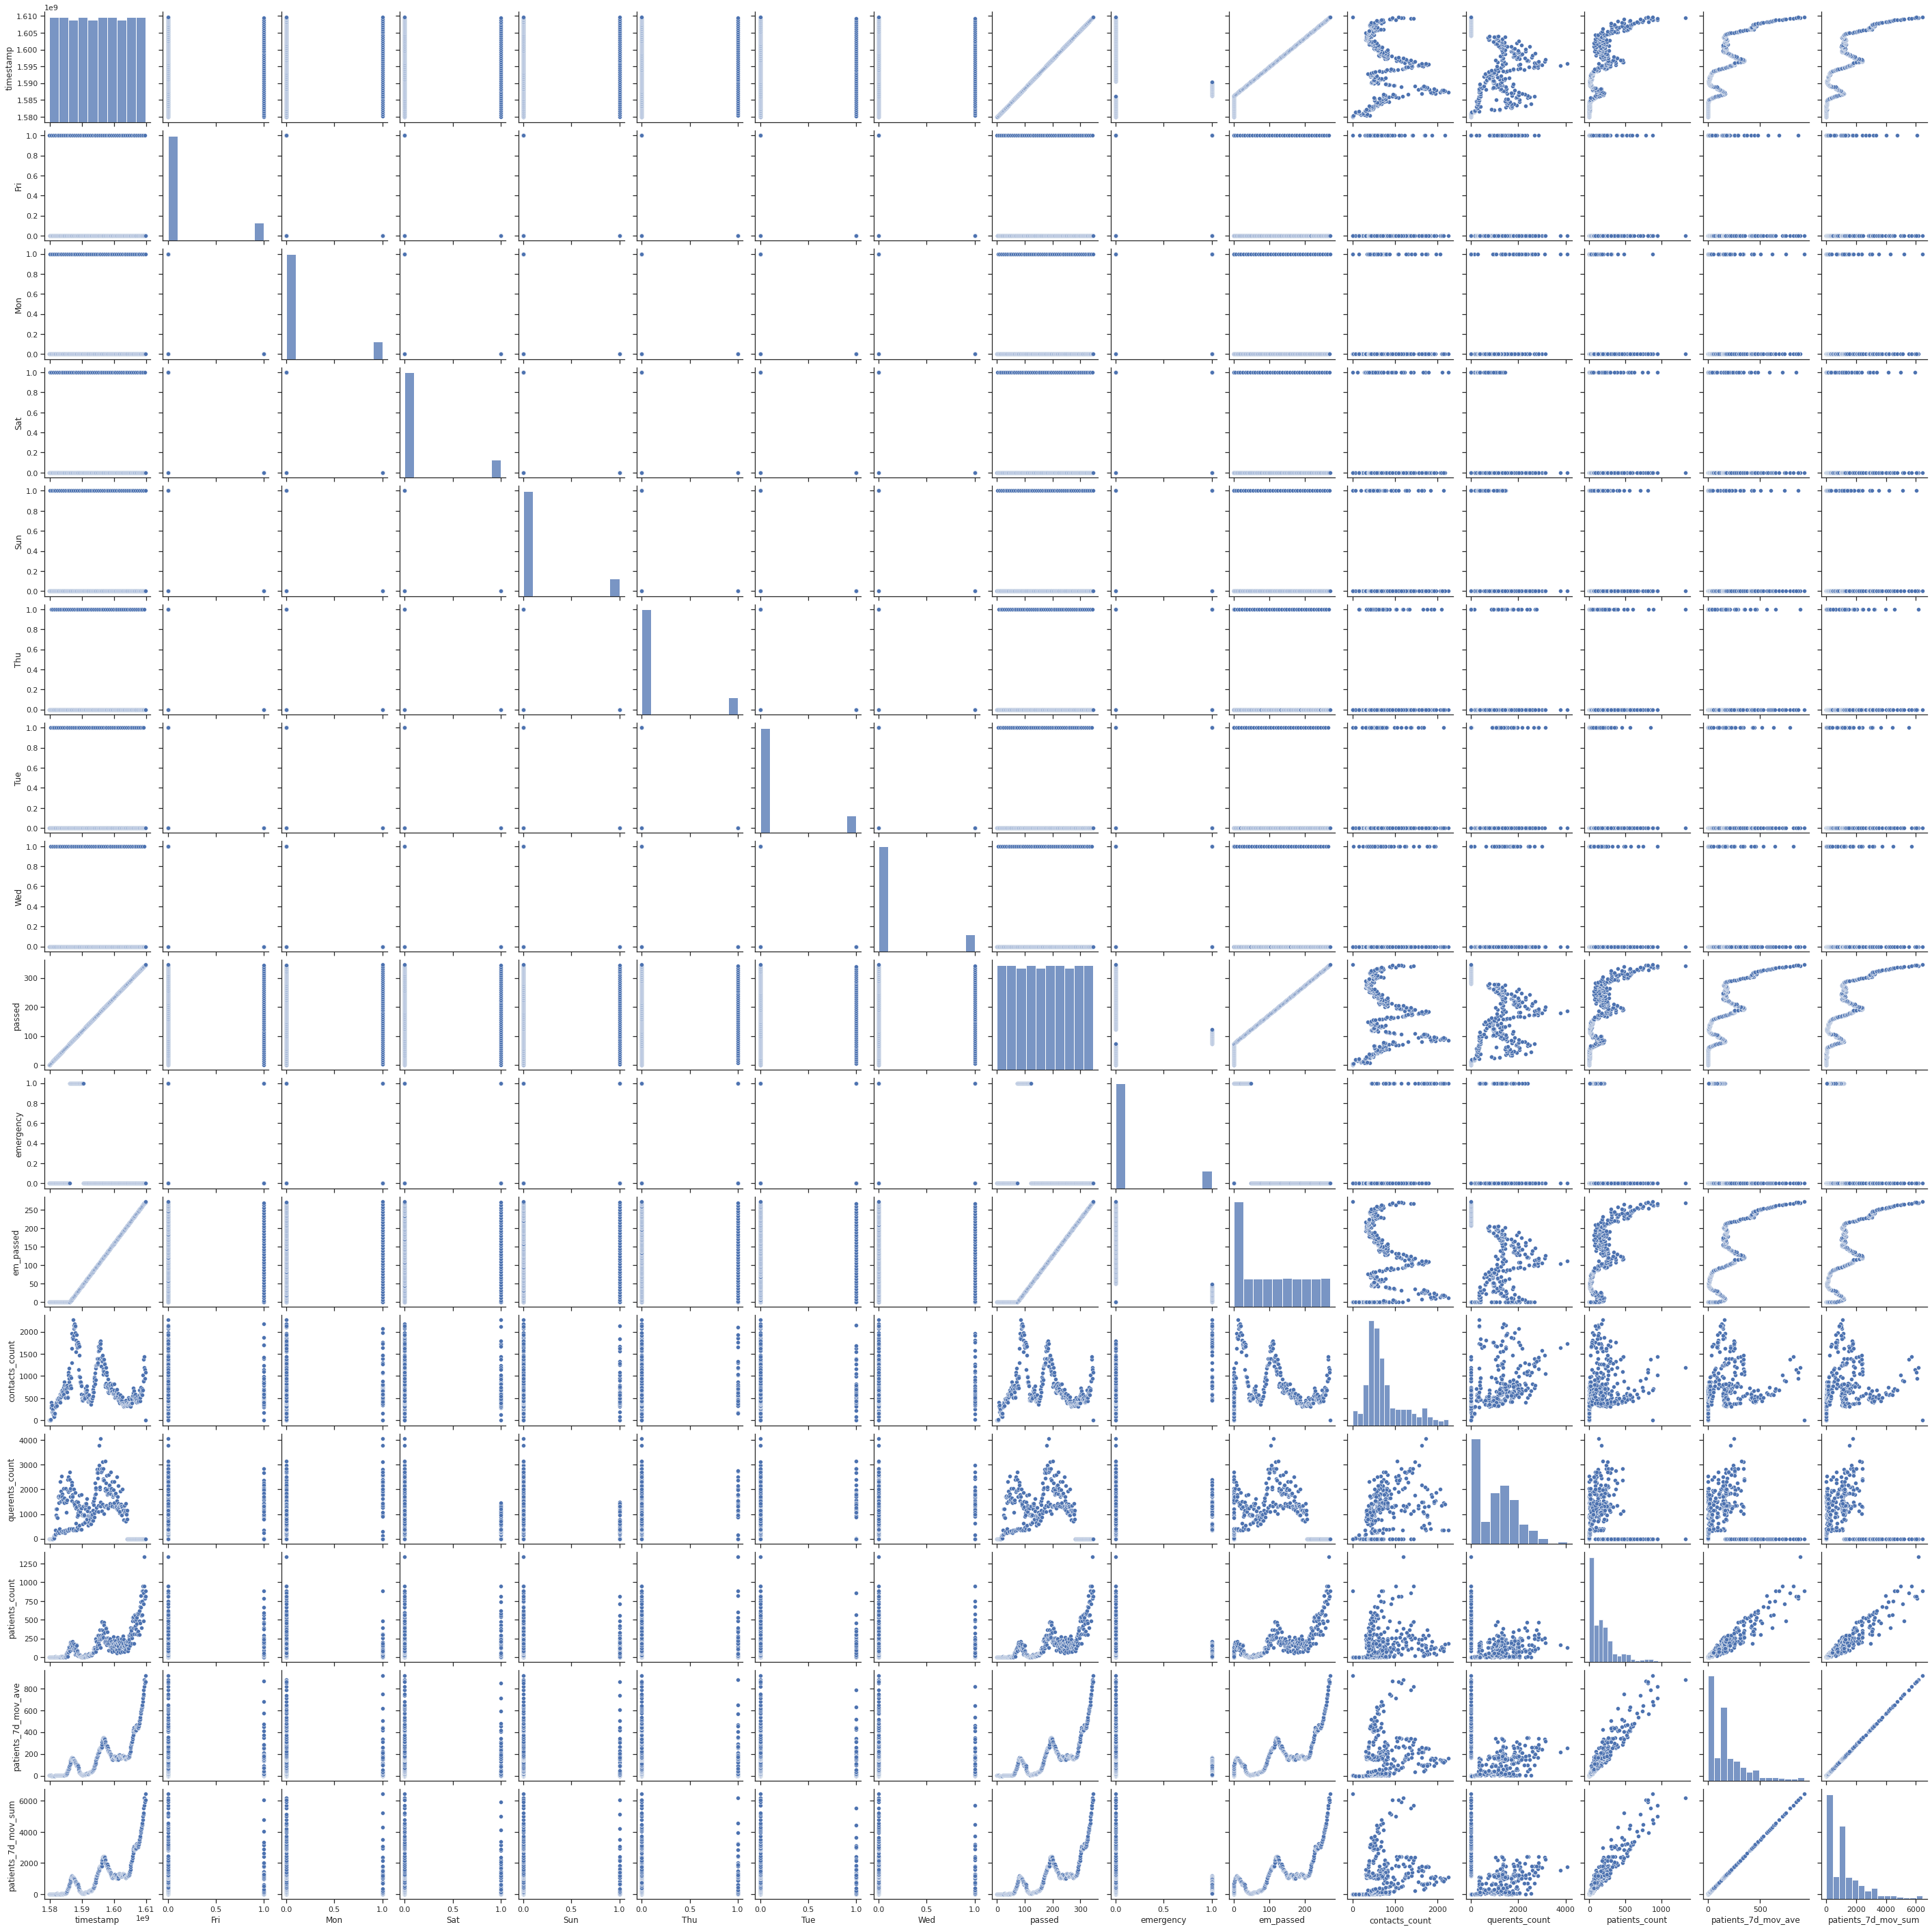

In [27]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=_df)

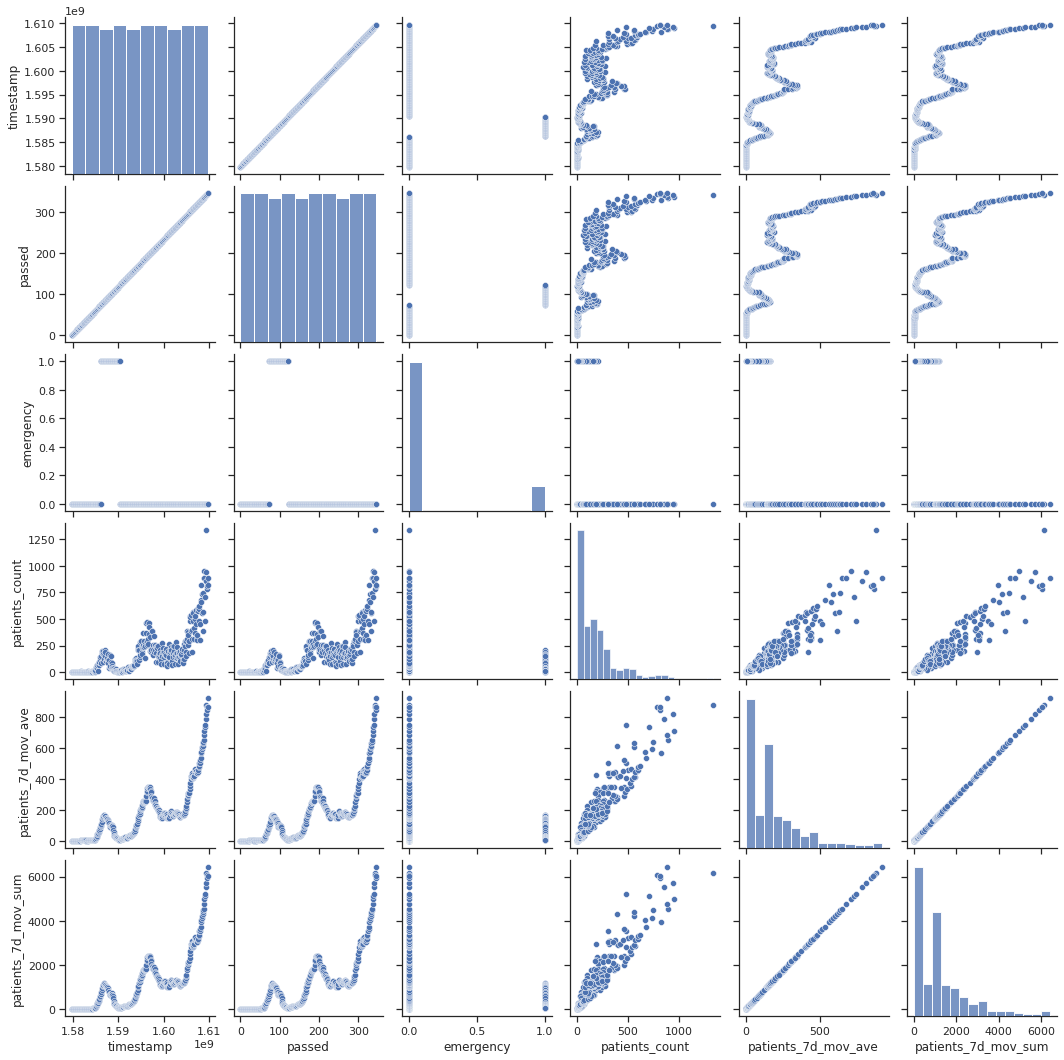

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.6.9
